# Example script for using GP beam fitter
Generates a test image and applies a beam mask. 
The region from the mask area is used to build a gaussian process (GP) model which is then used to predict the intensity over the full area. 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from beam_fitting import GP_beam_fitter
from scipy.ndimage import gaussian_filter

# Generate test image

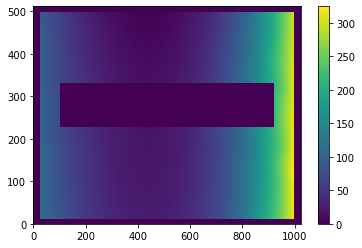

In [2]:
Nx,Ny = 1025,512
x = np.linspace(-1.0,1.0,num=Nx)
y = np.linspace(-1.0,1.0,num=Ny)
X,Y = np.meshgrid(x,y)

img = np.exp(-(X-0.2)**2-(Y+0.7)**2/1.5**2)
for n in range(1,7):
    img = img+((X-np.random.randn(1))**n)*np.random.randn(1)
    img = img+((Y-np.random.randn(1))**n)*np.random.randn(1)

img_noise = gaussian_filter(1+np.random.randn(Ny,Nx),(Ny/30,Nx/30))
img = img * img_noise

img = img - np.min(img)

beam_mask = 1.0-((np.abs(X)<0.8)*(np.abs(Y-0.1)<0.2))
beam_mask = beam_mask*(np.abs(X)<0.95)*(np.abs(Y)<0.95)
plt.pcolormesh(img*beam_mask)
plt.colorbar()

# Fit beam mask region

Null transmission mean = 0.999595
Null transmission rms = 0.005952


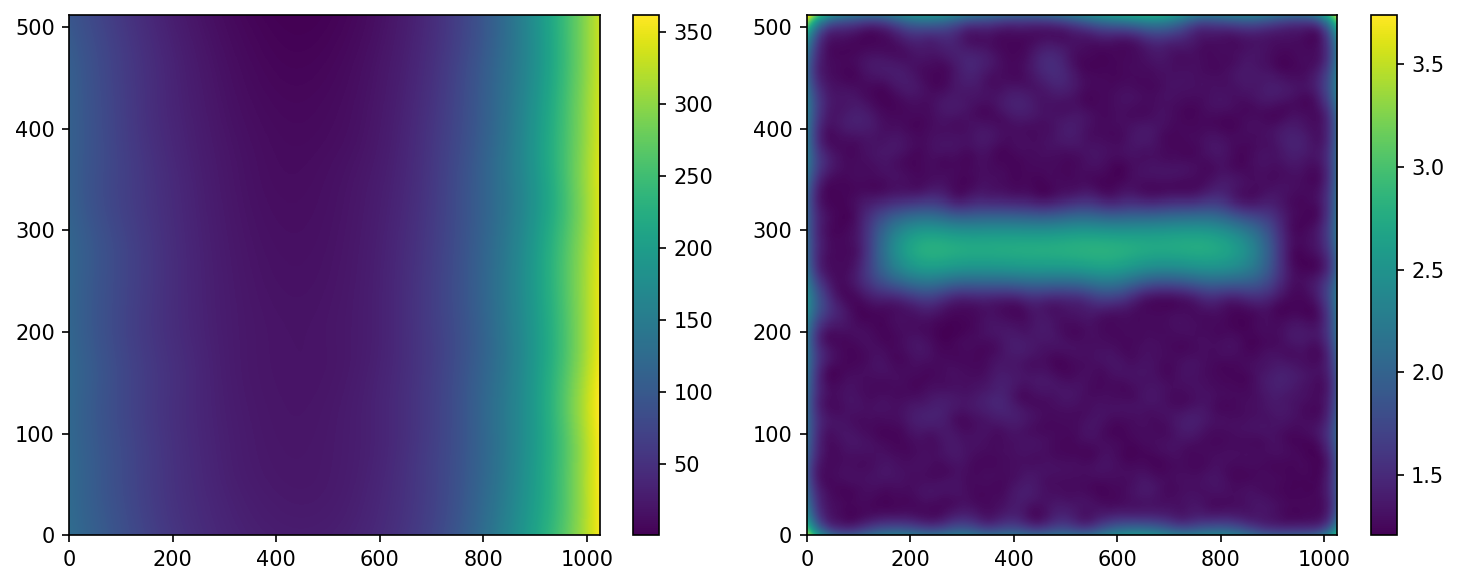

In [3]:
# mask is zero for areas you don't want to sample
BF = GP_beam_fitter(beam_mask,N_samples=1000)
beam_estimate,beam_uncertainty = BF.fit_beam(img)

fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=150)
pc1 = ax[0].pcolormesh(beam_estimate)
plt.colorbar(pc1,ax=ax[0])
pc2 = ax[1].pcolormesh(beam_uncertainty)
plt.colorbar(pc2,ax=ax[1])
plt.tight_layout()

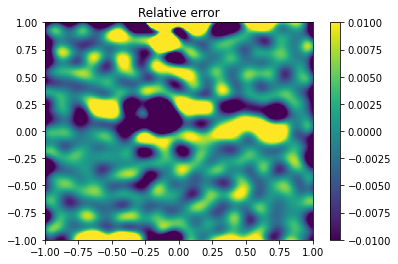

In [4]:

plt.pcolormesh(x,y,(beam_estimate-img)/beam_estimate,vmin=-0.02,vmax=0.02)
plt.colorbar()
plt.title('Relative error');


# Can use the model to generate sample profiles for Monte-Carlo error calculation
careful with how many grid points you want to sample over - it scales badly

In [5]:
%%time
N_s = (20,100)
x_s = np.linspace(-0.8,0.8,num=N_s[1],endpoint=True)
y_s = np.linspace(-0.1,0.3,num=N_s[0],endpoint=True)
[X_s,Y_s] = np.meshgrid(x_s,y_s)
XY_s = np.array([X_s.flatten(),Y_s.flatten()]).T

I_sample= BF.gp.sample_y(XY_s)
I_sample = I_sample.reshape(N_s)*(BF.imgMax-BF.imgMin)+BF.imgMin

CPU times: user 8.73 s, sys: 317 ms, total: 9.05 s
Wall time: 2.36 s


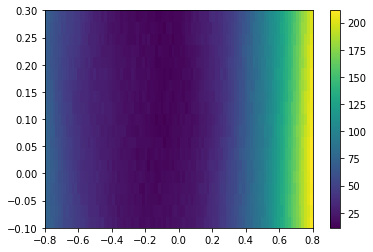

In [6]:
plt.pcolormesh(x_s,y_s,I_sample)
plt.colorbar()